# Digital bastards example

This notebook is a prototype of the type of workflow that we envision for
"digital bastards" as discussed during the [Lorentz
Workshop](https://www.lorentzcenter.nl/digital-bastards-for-a-climate-resilient-delta.html)
in November 2023. 

## From climate to impact

We present an online coupling between wflow (a hydrological model) and SFINCS (a
hydrodynamic model). This coupling is built upon the Basic Modelling Interface,
using [ewatercycle](https://ewatercycle.readthedocs.io/), as well as the
ewatercycle plugins for [wflow](https://github.com/eWaterCycle/pywflow) and
[sfincs](https://github.com/eWaterCycle/ewatercycle-sfincs). 

<img src="image.png" width="400">

## Case study: Humber

The workflow is build around a case study for the [Humber
estuary](https://en.wikipedia.org/wiki/Humber), investigating the 2013 cyclone
["Xaver"](https://en.wikipedia.org/wiki/Cyclone_Xaver).

<img src="uk_northsea_stormsurge_fig4a.jpg" width="600" alt="Alt Humber Estuary around the City of Hull with the flood depth footprint for Storm Xaver in 2013">

Figure source: [AIR](https://www.air-worldwide.com/publications/air-currents/2019/Managing-Storm-Surge-Risk-in-Great-Britain--A-Look-Back-at-the-North-Sea-Flood-of-1953-and-Xaver-in-2013/)

In [1]:
# %pip install ewatercycle
# %pip install git+https://github.com/eWaterCycle/grpc4bmi.git#egg=grpc4bmi[julia]
# %pip install ewatercycle-sfincs
# %pip install ewatercycle-wflowjl

# from ewatercycle_wflowjl.model import install_wflow
# install_wflow()


In [2]:
from ewatercycle.models import WflowJl, Sfincs
from ewatercycle.base.parameter_set import ParameterSet

import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from pathlib import Path
from rich import print


/home/peter/ewatercycle/ewatercycle/src/ewatercycle/config/__init__.py:196: UserWarning: Parameter set lisflood_fraser loaded in config but /home/peter/ewatercycle/ewatercycle/lisflood_fraser does not seem to exist.
  warnings.warn(
/home/peter/ewatercycle/ewatercycle/src/ewatercycle/config/__init__.py:201: UserWarning: Parameter set lisflood_fraser loaded in config but /home/peter/ewatercycle/ewatercycle/lisflood_fraser/settings_lat_lon-Run.xml does not seem to exist.
  warnings.warn(
/home/peter/ewatercycle/ewatercycle/src/ewatercycle/config/__init__.py:196: UserWarning: Parameter set pcrglobwb_rhinemeuse_30min loaded in config but /home/peter/ewatercycle/ewatercycle/pcrglobwb_rhinemeuse_30min does not seem to exist.
  warnings.warn(
/home/peter/ewatercycle/ewatercycle/src/ewatercycle/config/__init__.py:201: UserWarning: Parameter set pcrglobwb_rhinemeuse_30min loaded in config but /home/peter/ewatercycle/ewatercycle/pcrglobwb_rhinemeuse_30min/setup_natural_test.ini does not seem to 

Each model needs parameters sets. Often the combination of model and parameter set is actually what is called "model". At Deltares, the combination of parameters for the humber and the wflow model would be called the "wflow humber model". In the context of eWaterCycle, we decided to call this a model instance, to make a distinction between the model as a piece of software and the model instance as a combination of model and data.

In [3]:
# Parameter sets have been prepared by Deltares.

parameters_wflow = ParameterSet(
    name="humber",
    directory=Path("/home/peter/ewatercycle/wflow_humber"),
    target_model="WflowJl",
    config="wflow_sbm.toml"
)

parameters_sfincs = ParameterSet(
    name="humber",
    directory=Path("/home/peter/ewatercycle/sfincs_humber"),
    target_model="Sfincs",
    config="/home/peter/ewatercycle/sfincs_humber/sfincs.inp"
)

print(parameters_wflow)
print(parameters_sfincs)


ParameterSet(
    name='humber',
    directory=PosixPath('/home/peter/ewatercycle/wflow_humber'),
    config=PosixPath('wflow_sbm.toml'),
    doi='N/A',
    target_model='WflowJl',
    supported_model_versions=set(),
    downloader=None
)

ParameterSet(
    name='humber',
    directory=PosixPath('/home/peter/ewatercycle/sfincs_humber'),
    config=PosixPath('/home/peter/ewatercycle/sfincs_humber/sfincs.inp'),
    doi='N/A',
    target_model='Sfincs',
    supported_model_versions=set(),
    downloader=None
)

In [4]:
# In eWaterCycle, a model is instantiated by passing in a parameter set and
# (optionally) forcing. In this case the forcing is included in the parameter set.

from ewatercycle.container import ContainerImage

wflow = WflowJl(parameter_set=parameters_wflow)
# TODO get latest image through installed package
sfincs = Sfincs(bmi_image=ContainerImage('ghcr.io/ewatercycle/sfincs-bmiserver:20231105'), parameter_set=parameters_sfincs)  

print(wflow)
print(sfincs)


WflowJl(
    parameter_set=ParameterSet(
        name='humber',
        directory=PosixPath('/home/peter/ewatercycle/wflow_humber'),
        config=PosixPath('wflow_sbm.toml'),
        doi='N/A',
        target_model='WflowJl',
        supported_model_versions=set(),
        downloader=None
    ),
    forcing=None
)

Sfincs(
    parameter_set=ParameterSet(
        name='humber',
        directory=PosixPath('/home/peter/ewatercycle/sfincs_humber'),
        config=PosixPath('/home/peter/ewatercycle/sfincs_humber/sfincs.inp'),
        doi='N/A',
        target_model='Sfincs',
        supported_model_versions=set(),
        downloader=None
    ),
    forcing=None
)

In [5]:
# The setup function returns default configuration file for the corresponding
# parameter set. You can view and modify this if needed.

wflow_cfg_file, wflow_cfg_dir = wflow.setup()
print(wflow_cfg_file)

sfincs_cfg_file, sfincs_cfg_dir = sfincs.setup()
print(sfincs_cfg_file)


/home/peter/ewatercycle/technicalPaperExampleNotebooks/wflowjl_20231105_221419/wflow_ewatercycle.toml

/home/peter/ewatercycle/technicalPaperExampleNotebooks/sfincs_20231105_221421/sfincs.inp

In [6]:
# After possibly updating the settings, the configuration file is used to initalize the models

wflow.initialize(wflow_cfg_file)
sfincs.initialize(sfincs_cfg_file)
print(sfincs.output_var_names)


[ Info: Initialize model variables for model type `sbm`.
[ Info: Cyclic parameters are provided by `/home/peter/ewatercycle/wflow_humber/staticmaps.nc`.
[ Info: Forcing parameters are provided by `/home/peter/ewatercycle/wflow_humber/inmaps-era5-2013_xaver.nc`.
[ Info: Set `vertical.precipitation` using NetCDF variable `precip` as forcing parameter.
[ Info: Set `vertical.temperature` using NetCDF variable `temp` as forcing parameter.
[ Info: Set `vertical.potential_evaporation` using NetCDF variable `pet` as forcing parameter.
[ Info: Set `vertical.leaf_area_index` using NetCDF variable `LAI` as cyclic parameter.
┌ Info: General model settings
│   reservoirs = true
│   lakes = false
│   snow = true
│   masswasting = true
└   glacier = false
[ Info: Set `subcatchment` using NetCDF variable `wflow_subcatch`.
[ Info: Set `river_location` using NetCDF variable `wflow_river`.
[ Info: Set `lateral.river.width` using NetCDF variable `wflow_riverwidth`.
[ Info: Set `lateral.river.length` using

('z_xz', 'z_yz', 'zs', 'zb', 'qsrc_1', 'qsrc_2', 'xsrc', 'ysrc', 'tsrc', 'zst_bnd')

In [7]:
# Let's retrieve initial discharge field from wflow.
q_av = wflow.get_value_as_xarray("lateral.river.q_av")

# To see all available variables, you can use
# print(wflow.output_var_names)  # long list, uncomment to see all

q_av

<xarray.DataArray 'lateral.river.q_av' (time: 1, loc: 5453)>
array([[0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time     (time) datetime64[ns] 2013-11-25
  * loc      (loc) object MultiIndex
  * lon      (loc) float64 -1.795 -1.787 -1.778 -1.703 ... -1.753 -1.745 -1.77
  * lat      (loc) float64 52.38 52.38 52.38 52.38 ... 54.46 54.46 54.46 54.47
Attributes:
    units:    m3 s-1

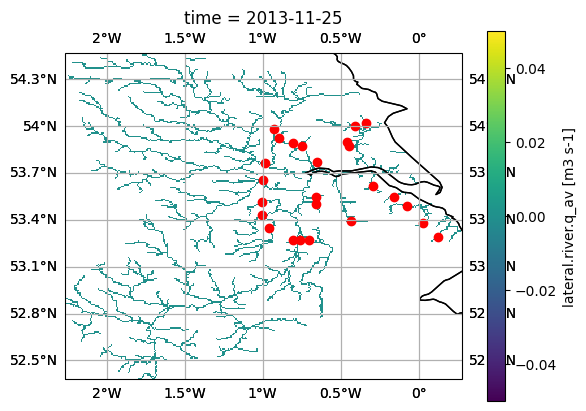

In [8]:
# Plot the initial field to get some feel for the wflow-domain
ax = plt.axes(projection=ccrs.PlateCarree())
q_av.unstack().isel(time=0).plot(ax=ax, x='lon', y='lat')
ax.coastlines()
ax.gridlines(draw_labels=True)

# Deltares has provided a list of points where wflow is coupled to sfincs
# We made a small utility function to load these locations
# Let's plot them on the map as well

from ewatercycle_wflowjl.utils import get_geojson_locs
wflow_lats, wflow_lons = get_geojson_locs("/home/peter/ewatercycle/wflow_humber/gauges_src.geojson")

ax.scatter(wflow_lons, wflow_lats, marker="o", c="red")
ax.coastlines()
ax.gridlines(draw_labels=True)


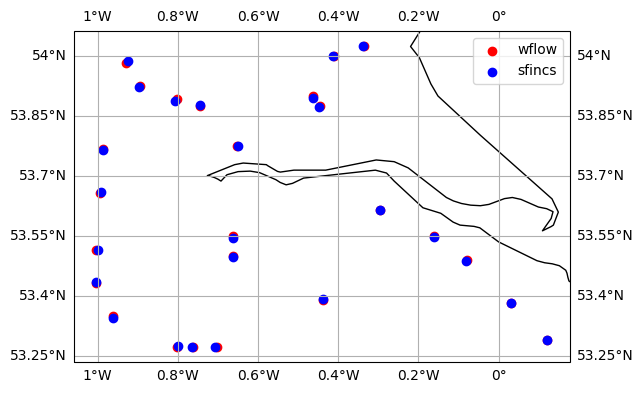

In [9]:
# Sfincs uses a different coordinate system and an unstuctured grid.
# The coupling points in sfincs coordinates are provided here:
with open('/home/peter/ewatercycle/sfincs_humber/sfincs.src', 'r') as srcfile:
    sfincs_points = srcfile.read().splitlines()

zipped = list(map(lambda x: x.split(' '), sfincs_points))
x_src, y_src = np.array(zipped, dtype='float').T

# Verify that the points overlap by plotting them in the same projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(wflow_lons, wflow_lats, marker="o", c="red", label='wflow')
ax.scatter(x_src, y_src, marker="o", c="blue", transform=ccrs.epsg(32630), label='sfincs')
ax.legend()
ax.coastlines()
ax.gridlines(draw_labels=True)

# We now know that we can use the same transform for plotting other fields from sfincs.


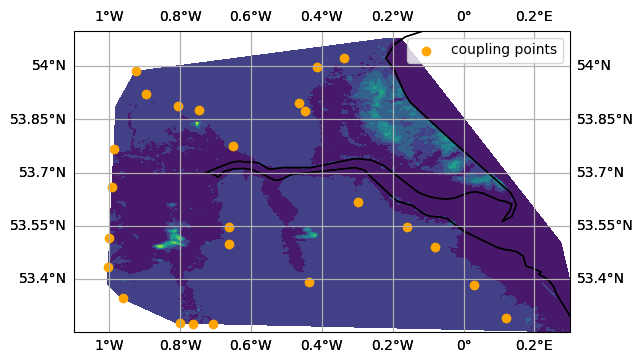

In [10]:
# Let's visualize the water level; use scatter for now because the grid is unstructured

zs = sfincs.get_value('zs')
z_xz = sfincs.get_value('z_xz')
z_yz = sfincs.get_value('z_yz')

ax = plt.axes(projection=ccrs.PlateCarree())
ax.tricontourf(z_xz, z_yz, zs, transform=ccrs.epsg(32630))  # crs taken from sfincs.inp
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-1.1, 0.3, 53.25, 54.1])

# Plot src points
ax.scatter(x_src, y_src, marker="o", c="orange", transform=ccrs.epsg(32630), label='coupling points')
ax.legend()
ax.coastlines()
ax.gridlines(draw_labels=True)


In [11]:
print(sfincs.output_var_names)

('z_xz', 'z_yz', 'zs', 'zb', 'qsrc_1', 'qsrc_2', 'xsrc', 'ysrc', 'tsrc', 'zst_bnd')

### Run models & capture output
This is the main loop of an eWaterCycle experiment. As long as the time variable of the model has not surpassed the end time of the experiment, `model.update()` runs a single timestep of a model. the `simulated_output` and `timestamps` arrays are filled with the calculated output of interest and timestamps respectivly using `model.get_value()` and `model.time`.

Coupling is achieved by taking the values of 'discharge' from the hydrologic model at certain locations and setting them using the `model.set_value_at_ind()` function into the hydrodynamic model.

In [12]:
simulated_output = []
timestamps = []

while (wflow.time < wflow.end_time):

    # Update the hydrological model. The order of updating and exchanging information is
    # very dependent on the definition of the information exchanged. Here it is assumed that
    # the discharge calculated by the hydrological model represents the average discharge over the timestep just
    # finished. This is given to the hydrodynamic model as (upstream) boundary condition
    wflow.update()

    # Get discharge from hydrological model at the locations of interest
    coupling_discharge = wflow.get_value_at_coords(
        "lateral.river.q_av",
        lat=wflow_lats,
        lon=wflow_lons,
    )

    # Set the boundary condition value in the hydrodynamic model.
    sfincs.set_value("qtsrc", np.array([sfincs_time, wflow.time]))  # TODO fix these time getters
    sfincs.set_value("qsrc_1", coupling_discharge)  # discharge at preceding time index
    sfincs.set_value("qsrc_2", coupling_discharge)  # discharge at exceeding time index
    sfincs.update_until(60*60)  # Note: should be update_until(wflow.time), but bug in sfincs bmi: supply dt instead


NameError: name 'sfincs_time' is not defined

The `timestamps` and `simulated_output` variables are now filled with datetime values and outputs for each simulated day.

In [ ]:
zs = sfincs.get_value('zs')
z_xz = sfincs.get_value('z_xz')
z_yz = sfincs.get_value('z_yz')

ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(z_xz, z_yz, c=zs, transform=ccrs.epsg(32630))  # crs taken from sfincs.inp, not sure if correct
ax.coastlines()
ax.gridlines(draw_labels=True)


### Clean up after the model run
The models have to be 'finalized', which deletes any temporary files and the containers have to be shut down.

In [ ]:
wflow.finalize()
sfincs.finalize()
